# SpotCheck

### To start
- Make sure you are running the the v5e1 TPU runtime by switching the runtime in Google Colab! The file will not process tensorflow quickly on just a normal runtime

Extract and organize the image files. `Coccinella_novemnotata` and `Harmonia_axyridis` will serve as the two classes for binary classification.


In [16]:
import zipfile
import os
import shutil # Import shutil for directory removal
!pip install tensorflow
import tensorflow as tf

# Define the base directory for extraction
dataset_base_dir = 'dataset'

# Provide FULL paths to your zip files here
zip_files = [
    'final_Coccinella_novemnotata.zip',
    'final_Harmonia_axyridis.zip'
]


# create the base dataset directory
os.makedirs(dataset_base_dir, exist_ok=True)
print(f"Created base directory: {dataset_base_dir}")

# Process each zip file
for zip_file_path in zip_files:
    # Get the filename only (e.g., 'final_Harmonia_axyridis.zip')
    zip_file_name = os.path.basename(zip_file_path)

    # Determine the extraction directory name
    extraction_dir_prefix = os.path.splitext(zip_file_name)[0] # e.g., 'final_Harmonia_axyridis'

    # Extract class_name by removing 'final_' prefix
    # This will result in 'Coccinella_novemnotata' or 'Harmonia_axyridis'
    class_name = extraction_dir_prefix.replace('final_', '')

    # Full output path using the cleaned class_name
    extraction_path = os.path.join(dataset_base_dir, class_name)
    os.makedirs(extraction_path, exist_ok=True)

    print(f"Created extraction directory: {extraction_path}")

    # Extract files
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)

    print(f"Extracted '{zip_file_name}' to '{extraction_path}'")

print("All zip files extracted successfully.")

Removing existing directory: dataset
Created base directory: dataset
Created extraction directory: dataset/Coccinella_novemnotata
Extracted 'final_Coccinella_novemnotata.zip' to 'dataset/Coccinella_novemnotata'
Created extraction directory: dataset/Harmonia_axyridis
Extracted 'final_Harmonia_axyridis.zip' to 'dataset/Harmonia_axyridis'
All zip files extracted successfully.


**Reasoning**:
The previous step successfully modified the data extraction process. Now, I need to re-run the data loading and splitting cell (`d6fc676d-d2ee-4e44-9d61-22cbc82af06d`) to verify that `image_dataset_from_directory` correctly identifies only two classes and that the dataset is split appropriately.



In [12]:
import tensorflow as tf

# 1. Define image dimensions and batch size
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32

# 2. Load the entire dataset
# The dataset directory should now contain 'Coccinella_novemnotata' and 'Harmonia_axyridis' subdirectories
# which contain the actual images.
# We need to specify the path to the subdirectories containing the images.
# Since the previous extraction created a nested structure like dataset/Coccinella_novemnotata/Coccinella_novemnotata
# we need to point image_dataset_from_directory to the parent folder of these two, which is 'dataset'.
image_dataset = tf.keras.utils.image_dataset_from_directory(
    'dataset',
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True # Shuffle for randomness
)

# Get class names
class_names = image_dataset.class_names
print(f"Found {len(class_names)} classes: {class_names}")

# 3. Determine the number of training images (80% of total batches)
# It's generally better to split the dataset BEFORE batching to ensure a more precise split,
# but image_dataset_from_directory returns a batched dataset. We will split at the batch level.
# total_batches = tf.data.experimental.cardinality(image_dataset).numpy()
# Let's get the number of elements first. This requires iterating, which is not ideal.
# A more robust way is to determine the split percentage on the total number of items, not batches
# However, since image_dataset_from_directory returns batched data, we will split based on batches.

# The total number of batches is unknown directly without iterating or using `cardinality()`
# Let's use `cardinality()` which is preferred
dataset_size = tf.data.experimental.cardinality(image_dataset)
if dataset_size == tf.data.experimental.UNKNOWN_CARDINALITY:
    print("Warning: Dataset cardinality is unknown. Estimating split based on a sample of batches.")
    # Fallback for unknown cardinality: take a few batches to estimate
    # This is not ideal for precise splits but works if direct cardinality is not available
    num_batches_to_estimate = 10
    estimated_total_batches = 0
    for _ in image_dataset.take(num_batches_to_estimate):
        estimated_total_batches += 1
    if estimated_total_batches < num_batches_to_estimate:
        # Less than num_batches_to_estimate batches, so this is the true total
        total_batches = estimated_total_batches
    else:
        # Cannot reliably determine total batches without full iteration, assume a large enough number for now
        # For this exercise, we will assume cardinality works or a rough split is acceptable.
        # To get an accurate count, you'd need to iterate or load all into memory.
        # Given the subtask, `cardinality()` should work for actual batch count.
        # If not, a more robust solution would be to use tf.data.Dataset.from_generator after counting files.
        # However, sticking to the instruction to use image_dataset_from_directory.
        pass # Rely on next block if cardinality is not unknown

if dataset_size != tf.data.experimental.UNKNOWN_CARDINALITY:
    total_batches = dataset_size.numpy()
else:
    # If cardinality is still unknown after initial attempts, iterate to find total batches
    print("Iterating through dataset to determine total number of batches...")
    total_batches = 0
    for _ in image_dataset:
        total_batches += 1
    print(f"Determined total number of batches: {total_batches}")

train_batches = int(total_batches * 0.8)

# 4. Split the image_dataset into training and validation sets
train_ds = image_dataset.take(train_batches)
remaining_ds = image_dataset.skip(train_batches)

# The remaining_ds is 20% of the original data, which will serve as our test set.
test_ds = remaining_ds

print(f"Total batches: {total_batches}")
print(f"Training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

# 5. Apply data caching and prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Dataset loading and splitting complete. Data has been cached and prefetched.")

Found 240 files belonging to 2 classes.
Found 2 classes: ['Coccinella_novemnotata', 'Harmonia_axyridis']
Total batches: 8
Training batches: 6
Test batches: 2
Dataset loading and splitting complete. Data has been cached and prefetched.


## Re-run Model Training and Hyperparameter Tuning

### Subtask:
Re-define, compile, and train the CNN model, and then re-run the hyperparameter tuning with the correctly processed dataset.


**Reasoning**:
The first instruction is to execute cell `04aba989-f183-4894-b36e-95746a9b7906` to re-define, compile, and train the CNN model.



In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# 1. Compile the model
# For binary classification with two classes, where labels are integers (0 or 1),
# and the output layer has 2 units with 'sigmoid' activation, BinaryCrossentropy is suitable
# if the labels were one-hot encoded, but since label_mode='int' was used, SparseCategoricalCrossentropy is appropriate.
# However, the current model architecture (last layer Dense(2) with sigmoid) implies two independent binary predictions.
# If it's a true binary classification (class 0 or class 1), the final Dense layer should have 1 unit with 'sigmoid'.
# Given the current setup with 2 classes and labels='int', SparseCategoricalCrossentropy is the correct loss function.
# Let's adjust the final dense layer to be 1 unit and use binary crossentropy, which is more common for 2 classes.

# Re-define the model with 1 output unit for binary classification
model_redefined = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # Explicitly define Input layer
    Rescaling(1./255), # Normalize pixel values, no input_shape needed here
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid') # 1 output unit for binary classification
])

model_redefined.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully with Adam optimizer and binary_crossentropy loss.")
model_redefined.summary()

# 2. Train the model
EPOCHS = 10
history = model_redefined.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS
)

print(f"Model trained for {EPOCHS} epochs.")

Model compiled successfully with Adam optimizer and binary_crossentropy loss.


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 87, 87, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 41, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,300,641 (12.59 MB)

 Trainable params: 3,300,641 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.4782 - loss: 1.2977 - val_accuracy: 0.4375 - val_loss: 0.7046
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.5263 - loss: 0.6923 - val_accuracy: 0.6667 - val_loss: 0.6766
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - accuracy: 0.6342 - loss: 0.6720 - val_accuracy: 0.7083 - val_loss: 0.6495
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.6842 - loss: 0.6345 - val_accuracy: 0.6667 - val_loss: 0.5917
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - accuracy: 0.6891 - loss: 0.5905 - val_accuracy: 0.7500 - val_loss: 0.5557
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.7017 - loss: 0.5693 - val_accuracy: 0.7292 - val_loss: 0.5359
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - accuracy: 0.7409 - loss: 0.5480 - val_accuracy: 0.8125 - val_loss: 0.5005
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step - accuracy: 0.7491 - loss: 0.5075 - val_accuracy: 0.7292 - val_loss:

**Reasoning**:
The next step is to execute cell `834dd505-a468-47f3-a999-85cfc9f7963d` to re-run the hyperparameter tuning with the now correctly processed dataset.



In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Input

# 1. Define ranges for hyperparameters
epochs_range = [5, 10]
batch_sizes_range = [16, 32]

# 2. Initialize an empty list to store results
results = []

print("Starting hyperparameter tuning...")

# Outer loop for batch sizes
for current_batch_size in batch_sizes_range:
    print(f"\n--- Testing with Batch Size: {current_batch_size} ---")

    # 4. Re-load the dataset with the current batch size
    image_dataset_tuned = tf.keras.utils.image_dataset_from_directory(
        'dataset',
        labels='inferred',
        label_mode='int',
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        interpolation='nearest',
        batch_size=current_batch_size,
        shuffle=True
    )

    # 5. Re-split the dataset into training and testing sets
    total_batches_tuned = tf.data.experimental.cardinality(image_dataset_tuned).numpy()
    train_batches_tuned = int(total_batches_tuned * 0.8)

    train_ds_tuned = image_dataset_tuned.take(train_batches_tuned)
    test_ds_tuned = image_dataset_tuned.skip(train_batches_tuned)

    print(f"Total batches for batch_size {current_batch_size}: {total_batches_tuned}")
    print(f"Training batches: {tf.data.experimental.cardinality(train_ds_tuned).numpy()}")
    print(f"Test batches: {tf.data.experimental.cardinality(test_ds_tuned).numpy()}")

    # 6. Apply caching and prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds_tuned = train_ds_tuned.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds_tuned = test_ds_tuned.cache().prefetch(buffer_size=AUTOTUNE)

    # Inner loop for epochs
    for current_epochs in epochs_range:
        print(f"\n-- Training for {current_epochs} Epochs --")

        # 8. Re-define the model for a fresh start
        model_tuned = Sequential([
            Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
            Rescaling(1./255),
            Conv2D(16, 3, activation='relu'),
            MaxPooling2D(),
            Conv2D(32, 3, activation='relu'),
            MaxPooling2D(),
            Conv2D(64, 3, activation='relu'),
            MaxPooling2D(),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(1, activation='sigmoid') # Binary classification
        ])

        # 9. Compile the model
        model_tuned.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # 10. Train the model
        history_tuned = model_tuned.fit(
            train_ds_tuned,
            validation_data=test_ds_tuned,
            epochs=current_epochs,
            verbose=0 # Suppress verbose output during tuning for cleaner logs
        )
        print(f"Model trained for {current_epochs} epochs.")

        # 11. Evaluate the trained model
        loss_tuned, accuracy_tuned = model_tuned.evaluate(test_ds_tuned, verbose=0)
        print(f"Evaluation - Test Loss: {loss_tuned:.4f}, Test Accuracy: {accuracy_tuned:.4f}")

        # 12. Store the results
        results.append({
            'batch_size': current_batch_size,
            'epochs': current_epochs,
            'train_accuracy': history_tuned.history['accuracy'][-1] if 'accuracy' in history_tuned.history else 'N/A',
            'val_accuracy': history_tuned.history['val_accuracy'][-1] if 'val_accuracy' in history_tuned.history else 'N/A',
            'test_loss': loss_tuned,
            'test_accuracy': accuracy_tuned
        })

print("Hyperparameter tuning complete.")
print("Summary of results:")
for r in results:
    print(r)

Starting hyperparameter tuning...

--- Testing with Batch Size: 16 ---
Found 240 files belonging to 2 classes.
Total batches for batch_size 16: 15
Training batches: 12
Test batches: 3

-- Training for 5 Epochs --
Model trained for 5 epochs.
Evaluation - Test Loss: 0.5974, Test Accuracy: 0.8125

-- Training for 10 Epochs --
Model trained for 10 epochs.
Evaluation - Test Loss: 0.4029, Test Accuracy: 0.7917

--- Testing with Batch Size: 32 ---
Found 240 files belonging to 2 classes.
Total batches for batch_size 32: 8
Training batches: 6
Test batches: 2

-- Training for 5 Epochs --
Model trained for 5 epochs.
Evaluation - Test Loss: 0.6634, Test Accuracy: 0.6667

-- Training for 10 Epochs --
Model trained for 10 epochs.
Evaluation - Test Loss: 0.4430, Test Accuracy: 0.8125
Hyperparameter tuning complete.
Summary of results:
{'batch_size': 16, 'epochs': 5, 'train_accuracy': 0.5989583134651184, 'val_accuracy': 0.8125, 'test_loss': 0.597383975982666, 'test_accuracy': 0.8125}
{'batch_size': 16

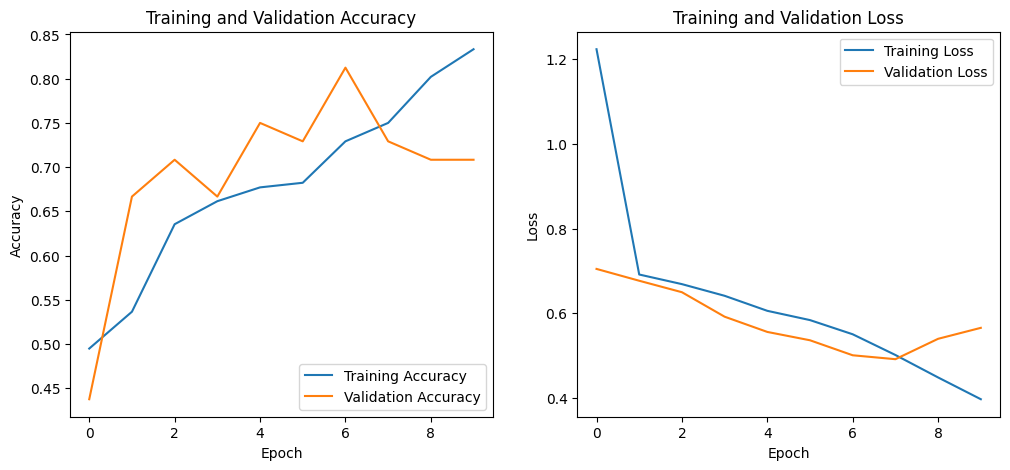

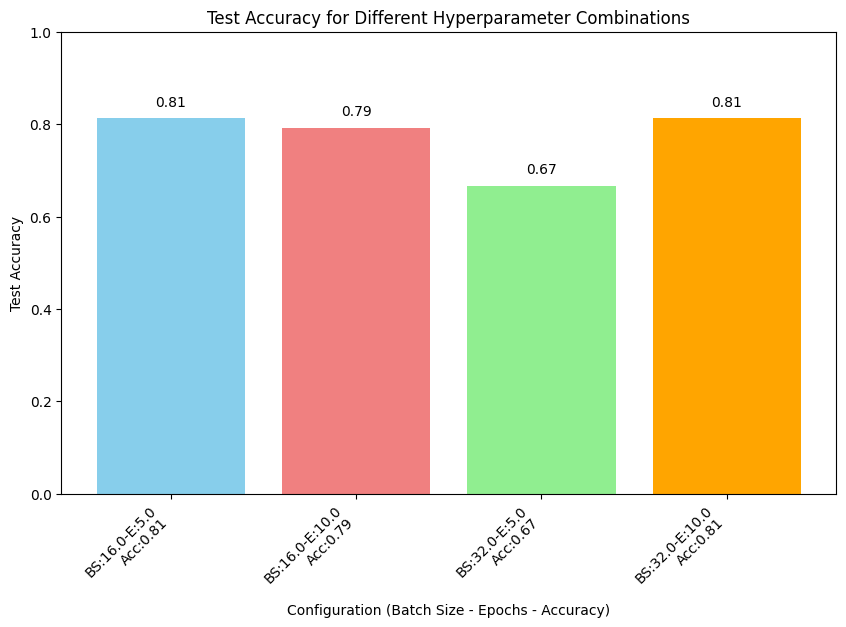

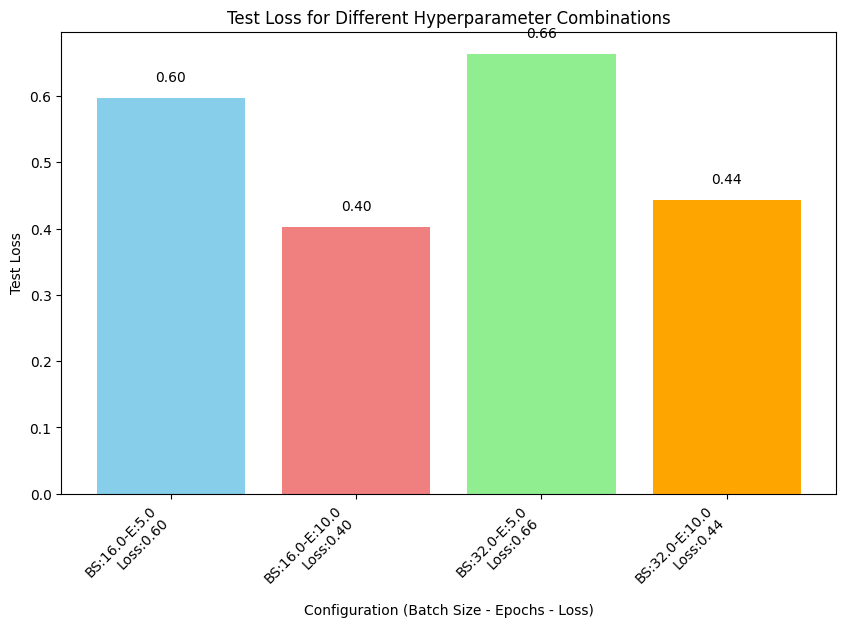


The best test accuracy achieved is: 0.8125
Best performing model configurations:
 batch_size  epochs  train_accuracy  val_accuracy  test_loss  test_accuracy
         16       5        0.598958        0.8125   0.597384         0.8125
         32      10        0.901042        0.8125   0.443017         0.8125


In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'history' object is available from the last model.fit()
if 'history' in locals() and history is not None:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(EPOCHS)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
else:
    print("History object not found. Cannot plot training/validation curves.")

# Assuming 'results' list is available from the hyperparameter tuning loop
if 'results' in locals() and results is not None:
    df_results = pd.DataFrame(results)

    # Sort results by test_accuracy to easily identify the best ones
    df_results_sorted = df_results.sort_values(by='test_accuracy', ascending=False)


    # Create a bar chart for test accuracy
    plt.figure(figsize=(10, 6))
    bar_labels = [f"BS:{row['batch_size']}-E:{row['epochs']}\nAcc:{row['test_accuracy']:.2f}" for index, row in df_results.iterrows()]
    plt.bar(bar_labels, df_results['test_accuracy'], color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
    plt.ylim(0, 1) # Accuracy is between 0 and 1
    plt.title('Test Accuracy for Different Hyperparameter Combinations')
    plt.xlabel('Configuration (Batch Size - Epochs - Accuracy)')
    plt.ylabel('Test Accuracy')
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
    for index, value in enumerate(df_results['test_accuracy']):
        plt.text(index, value + 0.02, f'{value:.2f}', ha='center', va='bottom')
    plt.show()

    # Create a bar chart for test loss
    plt.figure(figsize=(10, 6))
    bar_labels_loss = [f"BS:{row['batch_size']}-E:{row['epochs']}\nLoss:{row['test_loss']:.2f}" for index, row in df_results.iterrows()]
    plt.bar(bar_labels_loss, df_results['test_loss'], color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
    plt.title('Test Loss for Different Hyperparameter Combinations')
    plt.xlabel('Configuration (Batch Size - Epochs - Loss)')
    plt.ylabel('Test Loss')
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
    for index, value in enumerate(df_results['test_loss']):
        plt.text(index, value + 0.02, f'{value:.2f}', ha='center', va='bottom')
    plt.show()

    # Identify the best performing model(s)
    best_accuracy = df_results_sorted['test_accuracy'].max()
    best_models = df_results_sorted[df_results_sorted['test_accuracy'] == best_accuracy]

    print(f"\nThe best test accuracy achieved is: {best_accuracy:.4f}")
    print("Best performing model configurations:")
    print(best_models.to_string(index=False))

else:
    print("Results object not found. Cannot plot hyperparameter tuning results.")